In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import pickle

### Defining Double Pendulum System

In [2]:
class DoublePendulumSystem:

    def __init__(self, M1, M2, L1, L2):
        self.M1 = M1
        self.M2 = M2
        self.L1 = L1
        self.L2 = L2
        self.grav = 9.81
    
    def solve_ddphi1(self, phi1, dphi1, phi2, dphi2, M1, M2, L1, L2, grav):
        numerator = (
            -grav * (2 * M1 + M2) * np.sin(phi1)
            - M2 * grav * np.sin(phi1 - 2 * phi2)
            - 2 * np.sin(phi1 - phi2) * M2 * (dphi2**2 * L2 + dphi1**2 * L1 * np.cos(phi1 - phi2))
        )
        
        denominator = L1 * (2 * M1 + M2 - M2 * np.cos(2 * phi1 - 2 * phi2))

        return numerator / denominator

    def solve_ddphi2(self, phi1, dphi1, phi2, dphi2, M1, M2, L1, L2, grav):
        numerator = (
            2 * np.sin(phi1 - phi2)
            * (
                dphi1**2 * L1 * (M1 + M2)
                + grav * (M1 + M2) * np.cos(phi1)
                + dphi2**2 * L2 * M2 * np.cos(phi1 - phi2)
            )
        )

        denominator = L2 * (2 * M1 + M2 - M2 * np.cos(2 * phi1 - 2 * phi2))

        return numerator / denominator

    def deriv(self, t_now, q_now):
        M1 = self.M1
        M2 = self.M2
        L1 = self.L1
        L2 = self.L2
        grav = self.grav
    
        # Unpack the phi values and their first derivatives
        phi1, dphi1, phi2, dphi2 = q_now

        ddphi1 = self.solve_ddphi1(phi1, dphi1, phi2, dphi2, M1, M2, L1, L2, grav)
        ddphi2 = self.solve_ddphi2(phi1, dphi1, phi2, dphi2, M1, M2, L1, L2, grav)

        d_array = np.array([dphi1, ddphi1, dphi2, ddphi2])

        return d_array



### Finding General Poincare Sections of Varying Initial Release Angle of the Second Mass

In [ ]:
%run poincare_general

# Runs for 41 minutes on Intel Core i5 10th Gen

In [12]:
with open('bin/poincare_general_varying_phi2.pkl', 'rb') as f:
    solutions_poincare_general = pickle.load(f)

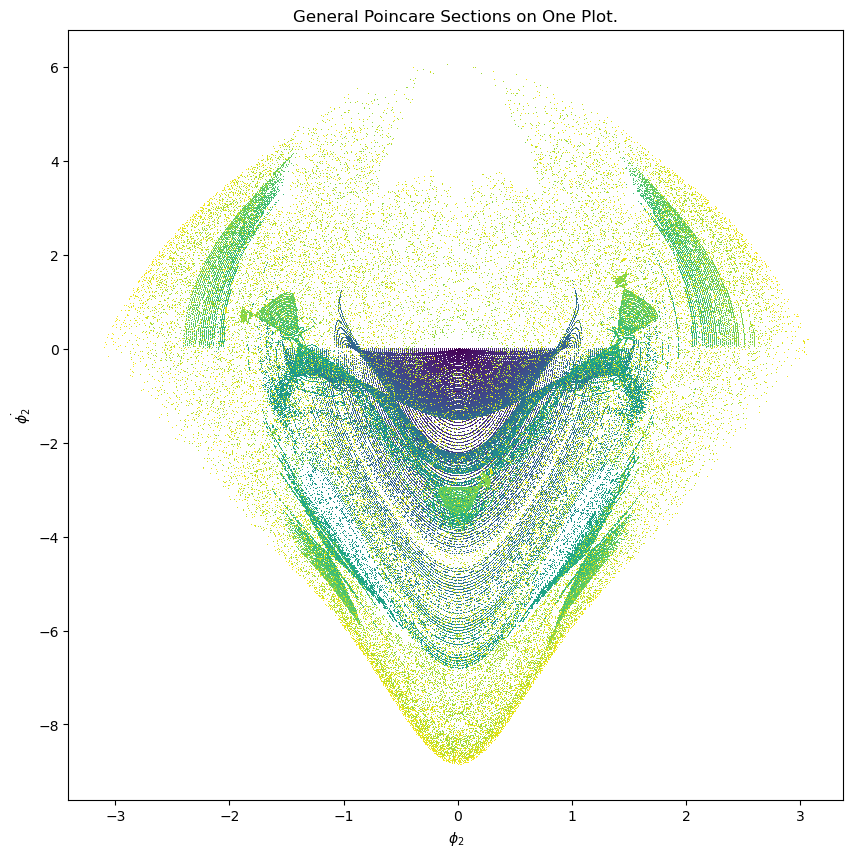

In [19]:
from matplotlib import colormaps

fig, ax = plt.subplots(figsize=(10, 10))

cmap = colormaps['viridis']

n = 1/len(solutions_poincare_general)

i = 0

for solution in solutions_poincare_general:
    poincare_states = solution.y_events[0] 
    phi2_values = poincare_states[:, 2]
    dphi2_values = poincare_states[:, 3]


    phi2_modulo = (phi2_values + np.pi)%(2*np.pi)-np.pi

    length = len(phi2_modulo)

    ax.plot(phi2_modulo[round(length/8):], dphi2_values[round(length/8):], ',', linestyle='None', color=cmap(i))

    i += n

ax.set_xlabel('$\\phi_2$')
ax.set_ylabel('$\\dot{\\phi_2}$')
ax.set_title('General Poincare Sections on One Plot.')
plt.show()

### Animation of Poincare Sections

In [14]:
poincare_general_sections = []

for solution in solutions_poincare_general:
    poincare_states = solution.y_events[0] 
    phi2_values = poincare_states[:, 2]
    dphi2_values = poincare_states[:, 3]


    phi2_modulo = (phi2_values + np.pi)%(2*np.pi)-np.pi

    length = len(phi2_modulo)

    poincare_general_sections.append([phi2_modulo[round(length/8):], dphi2_values[round(length/8):]])

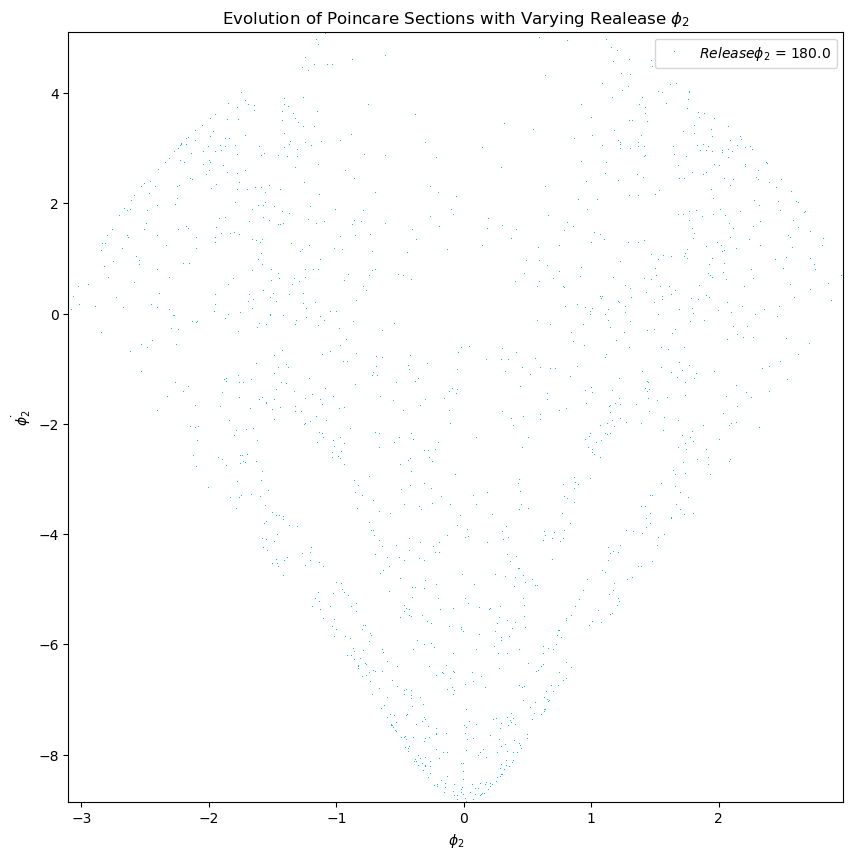

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

solutions = poincare_general_sections
labels = [f"Plot {i}" for i in range(len(solutions))]
phi2_str = "$Release  \\phi_2$"

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
lines = [ax.plot(sol[0], sol[1], alpha=0.0, label=labels[i], linestyle="None", marker=",")[0] for i, sol in enumerate(solutions)]

ax.set_xlim(min(solutions[-1][0]), max(solutions[-1][0]))
ax.set_ylim(min(solutions[-1][1]), max(solutions[-1][1]))
ax.set_xlabel('$\\phi_2$')
ax.set_ylabel('$\\dot{\\phi_2}$')
ax.set_title('Evolution of Poincare Sections with Varying Realease $\\phi_2$')


# Legend object (initially empty)
legend = ax.legend(handles=[], loc='upper right')

# Animation parameters
n = len(solutions)
visible_count = 1
total_frames = n + visible_count - 1

def update(frame):
    # Set visibility based on current frame
    for i, line in enumerate(lines):
        if frame <= i < frame + visible_count:
            line.set_alpha(1.0)
        else:
            line.set_alpha(0.0)

    # Update legend with currently visible lines
    visible_lines = [line for line in lines if line.get_alpha() > 0.5]
    ax.legend(visible_lines, [f'{phi2_str} = {np.round(solutions_poincare_general[int(line.get_label()[5:])].y[2][0]/np.pi*180, 2)}' for line in visible_lines], loc='upper right')

    return lines

ani = FuncAnimation(fig, update, frames=total_frames, interval=150, blit=True)

ani.save('media/general_poincare_evolution_animation.gif', dpi=100, writer=PillowWriter(fps=4, bitrate=3000))
#ani.save("media/general_poincare_evolution_animation.mp4", fps=4, dpi=200, bitrate=3000, writer="ffmpeg")

### Creating Bifurcation Diagram

In [ ]:
%run bifurcation.py

# Runs for 22 minutes on Intel Core i5 10th Gen

In [335]:
with open('bin/bifurcation_varying_phi2.pkl', 'rb') as f:
    solutions_bifurcation = pickle.load(f)

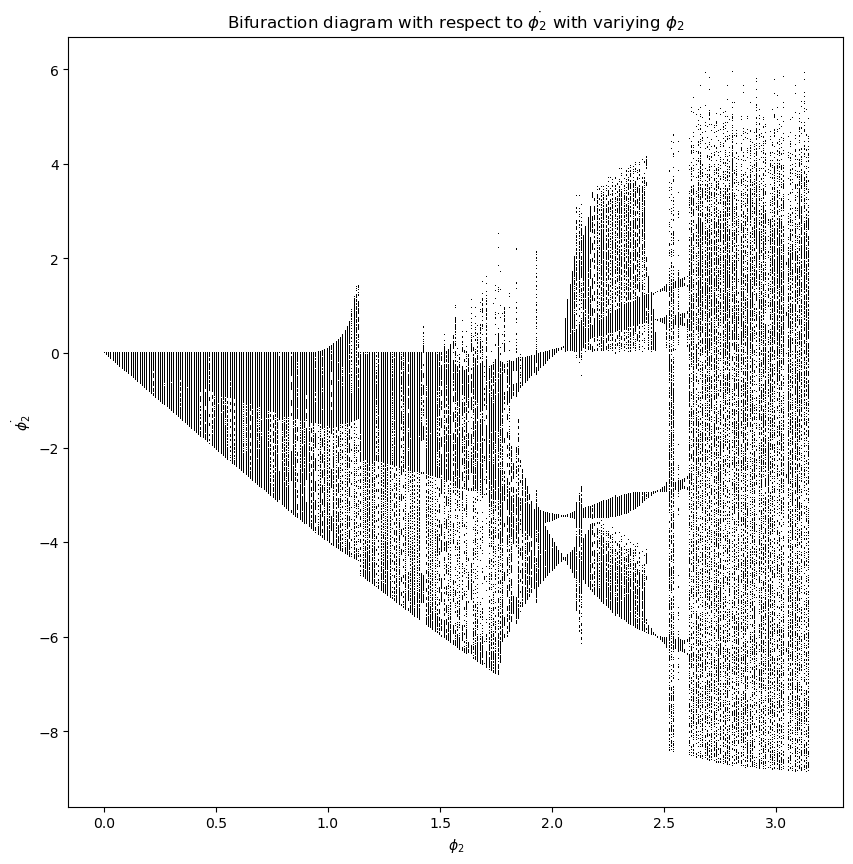

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for solution in solutions_bifurcation:

    poincare_states = solution.y_events[0]
    phi2_values = poincare_states[:, 2]
    dphi2_values = poincare_states[:, 3]

    phi2_release = solution.y[2][0]

    phi2_release_array = np.empty(len(dphi2_values))
    phi2_release_array.fill(phi2_release)
    

    ax.plot(phi2_release_array, dphi2_values, linestyle='None', color="black", marker=',', markersize=0.1)

ax.set_xlabel('$\\phi_2$')
ax.set_ylabel('$\\dot{\\phi_2}$')
ax.set_title('Bifuraction diagram with respect to $\\dot{\\phi_2}$ with variying $\\phi_2$.')

plt.savefig(fname="media/bifurcation.png", transparent=None, dpi=500)

plt.show()



### Exploring and Visualizing Specific Poincare Sections

In [ ]:
%run poincare_specific.py

# Runs for 142 minutes on Intel Core i5 10th Gen

In [333]:
solutions_specific = []

In [334]:
with open('bin/poincare_specific_phi2_0.0_T_0.1.pkl', 'rb') as f:
    solutions_specific.append(pickle.load(f))

with open('bin/poincare_specific_phi2_126.05_T_0.1.pkl', 'rb') as f:
    solutions_specific.append(pickle.load(f))

with open('bin/poincare_specific_phi2_179.91_T_0.1.pkl', 'rb') as f:
    solutions_specific.append(pickle.load(f))

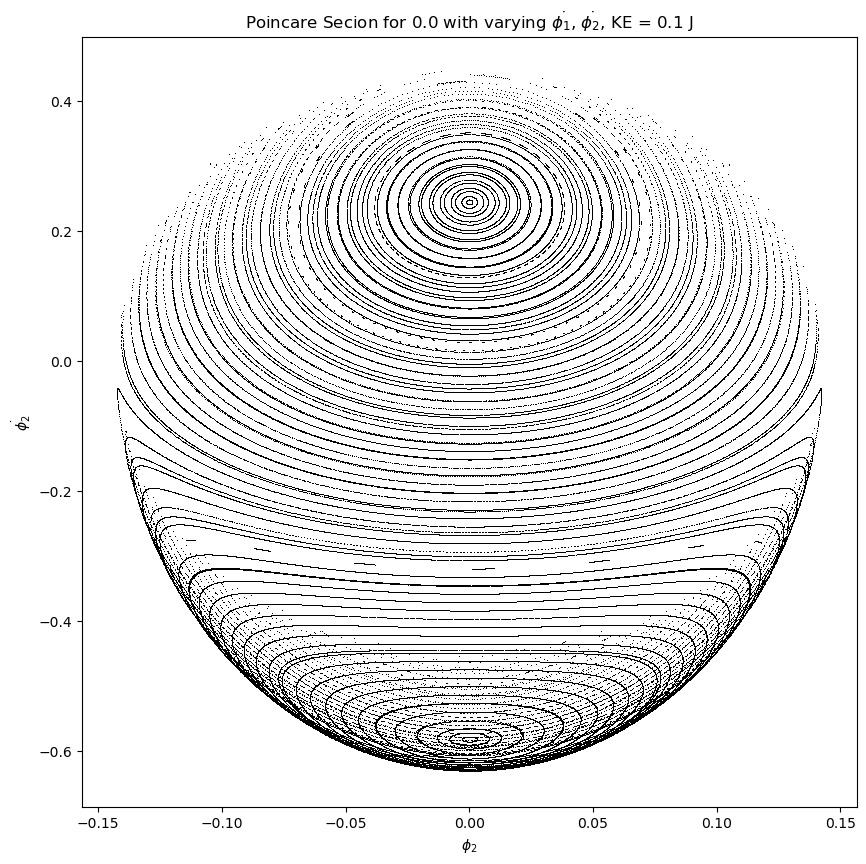

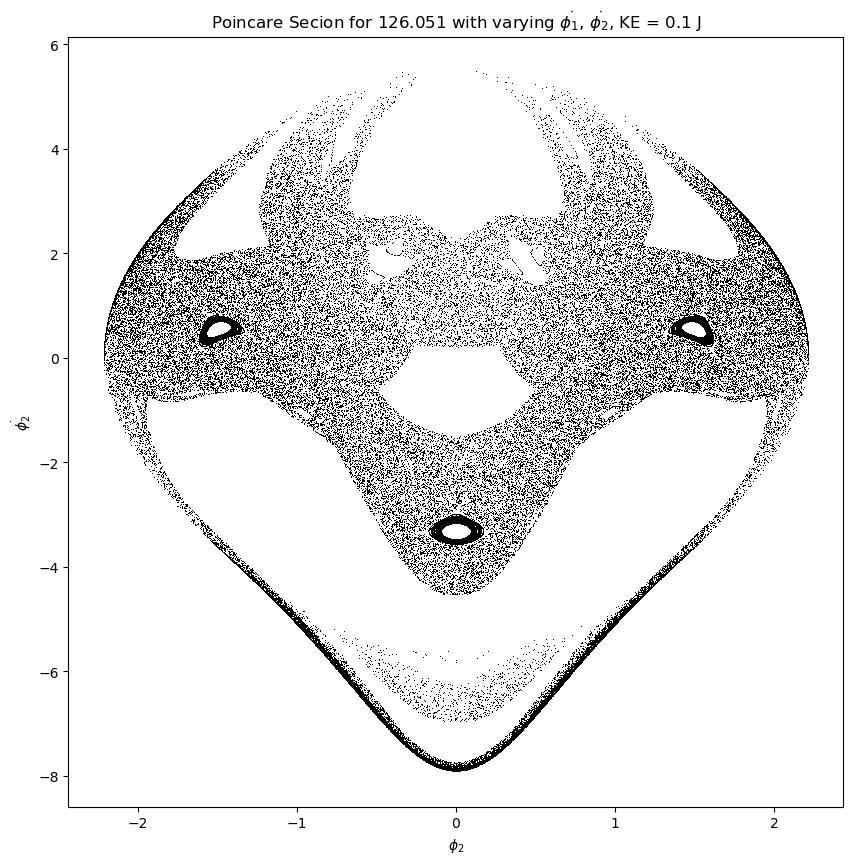

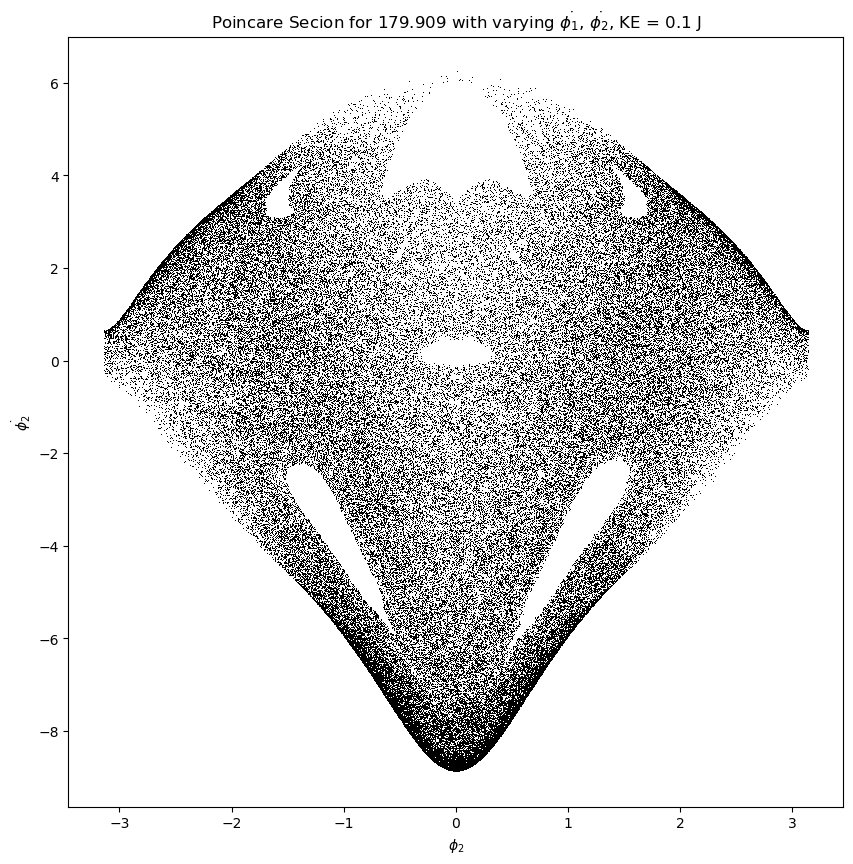

In [ ]:
phi2_specific_array = np.array([0, 2.2, 3.14])
phi2_specific_array = np.round(np.degrees(phi2_specific_array), 3)

i = 0

for solutions in solutions_specific:

    fig, ax = plt.subplots(figsize=(10, 10))

    for solution in solutions:
        poincare_states = solution.y_events[0]
        phi2_values = poincare_states[:, 2]
        dphi2_values = poincare_states[:, 3]

        phi2_modulo = (phi2_values + np.pi)%(2*np.pi)-np.pi

        cut_index = int(len(phi2_modulo) / 10)

        ax.plot(phi2_modulo[cut_index:], dphi2_values[cut_index:], linestyle='None', color="black", marker=',', markersize=0.001)

        
    ax.set_xlabel('$\\phi_2$')
    ax.set_ylabel('$\\dot{\\phi_2}$')
    dphi1_str = "$\\dot{\\phi_1}$"
    dphi2_str = "$\\dot{\\phi_2}$"
    ax.set_title(f'Poincare Secion for {phi2_specific_array[i]} with Varying {dphi1_str}, {dphi2_str}, KE = 0.1 J.')
    plt.savefig(fname=f"media/poincare_section_{phi2_specific_array[i]}.png", transparent=None, dpi=500)
    i += 1
    
    plt.show()


### Lyapunov Exponent and Divergence of Two Simulations with Close IVs.

In [3]:
system = DoublePendulumSystem(1, 1, 1, 1)

delta = 1e-15

release_angle = np.radians(145)

phi_init_0 = np.array([release_angle, 0, release_angle, 0])
phi_init_1 = np.array([release_angle, 0, release_angle + delta, 0])

t_start = 0
t_end = 60
t_span = [t_start, t_end] 
t_arr = np.linspace(t_start, t_end, 3600)


solution_0 = solve_ivp(system.deriv, t_span, phi_init_0,
                            t_eval = t_arr,
                            rtol = 1e-15, atol = 1e-15)

solution_1 = solve_ivp(system.deriv, t_span, phi_init_1,
                            t_eval = t_arr,
                            rtol = 1e-15, atol = 1e-15)

c:\Users\akram\miniconda3\envs\phy234\Lib\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


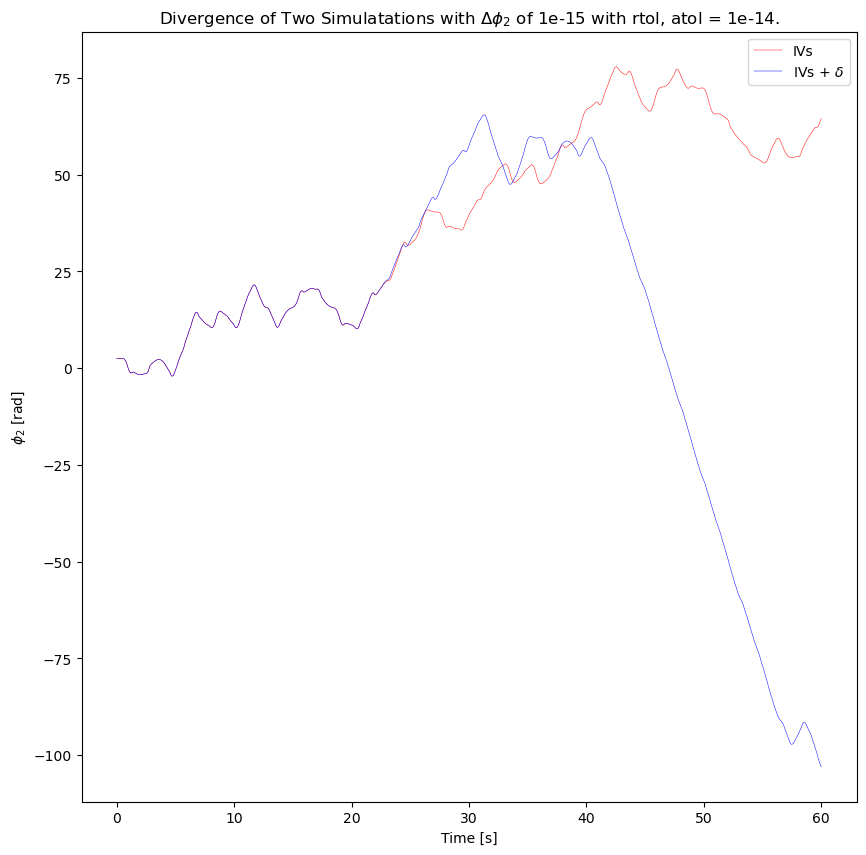

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(solution_0.t, solution_0.y[2], color="red", linewidth=0.35, label="IVs")
ax.plot(solution_1.t, solution_1.y[2], color="blue", linewidth=0.35, label="IVs + $\\delta$")

plt.savefig(fname="media/divergence.png", transparent=None, dpi=500)

plt.title(f"Divergence of Two Simulatations with $\\Delta \\phi_2$ of {delta} with rtol, atol = 1e-14.")
plt.xlabel('Time [s]')
plt.ylabel('$\\phi_2$ [rad]')
plt.legend()

plt.show()

In [ ]:
def fit_func (x, b, m) :
    return x*m + b

time_array = solution_0.t

epsilon = 1e-36

log_diff = np.log10(np.abs(solution_0.y[2]-solution_1.y[2]) + epsilon)

peak_indicies = find_peaks(log_diff, distance=10)[0] # Find only peaks separated by 10 samples
log_diff_peaks = log_diff[peak_indicies]
time_peaks = time_array[peak_indicies]

cutoff_time = 25

time_to_fit = time_peaks[time_peaks < cutoff_time]
log_diff_to_fit = log_diff_peaks[:len(time_to_fit)]

initital_guess = (1, 1)

popt, pcov = curve_fit(fit_func, time_to_fit, log_diff_to_fit, initital_guess)

b, m = popt

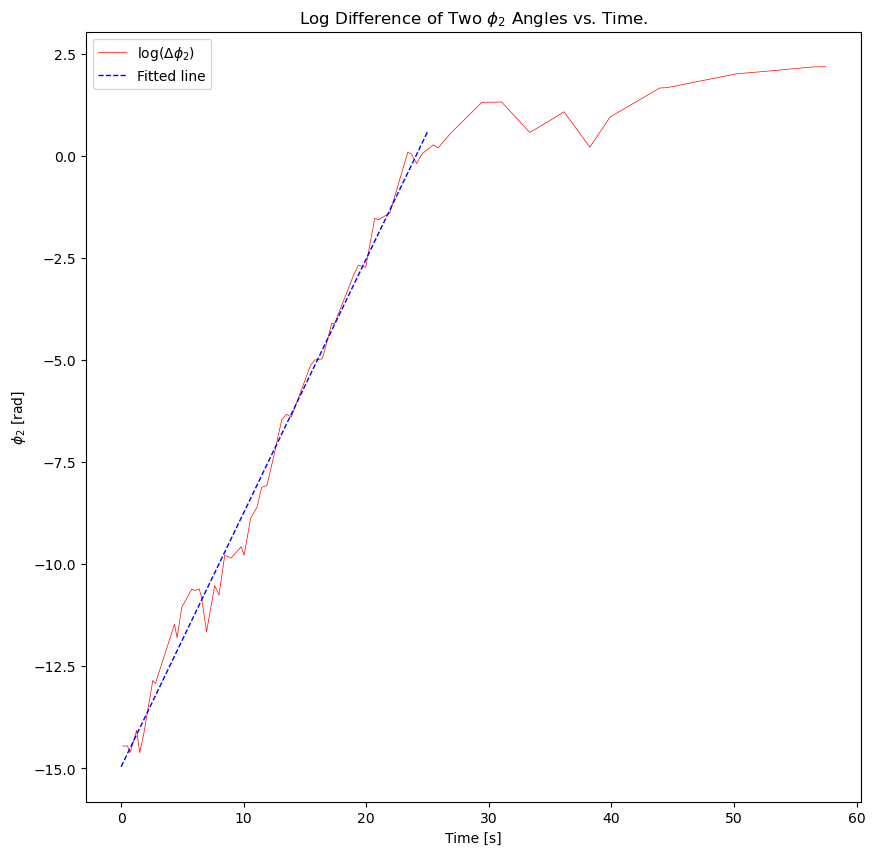

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(time_peaks, log_diff_peaks, color="red", linewidth=0.5, label="$\\log(\\Delta \\phi_2)$")

ax.plot(time_array[time_array < cutoff_time], b + m*time_array[time_array < cutoff_time], color='blue', linewidth=1, linestyle="--", label="Fitted line")

plt.xlabel('Time [s]')
plt.ylabel('$\\phi_2$ [rad]')
plt.title('Log Difference of Two $\\phi_2$ Angles vs. Time.')
plt.legend()

plt.savefig(fname="media/log_difference.png", transparent=None, dpi=500)

plt.show()

In [8]:
lyapunov_exponent = m

divergence_time = 1/lyapunov_exponent*np.log10(1/delta)

print(
    f'The system with Lyapunov exponent of {np.round(lyapunov_exponent, 3)} '
    f'started from two ICs differed by {delta} diverges at {np.round(divergence_time, 3)} seconds.'
)

The system with Lyapunov exponent of 0.622 started from two ICs differed by 1e-15 diverges at 24.124 seconds.


**The system with Lyapunov exponent of 0.622 started from two ICs differed by 1e-15 diverges at 24.124 seconds.**

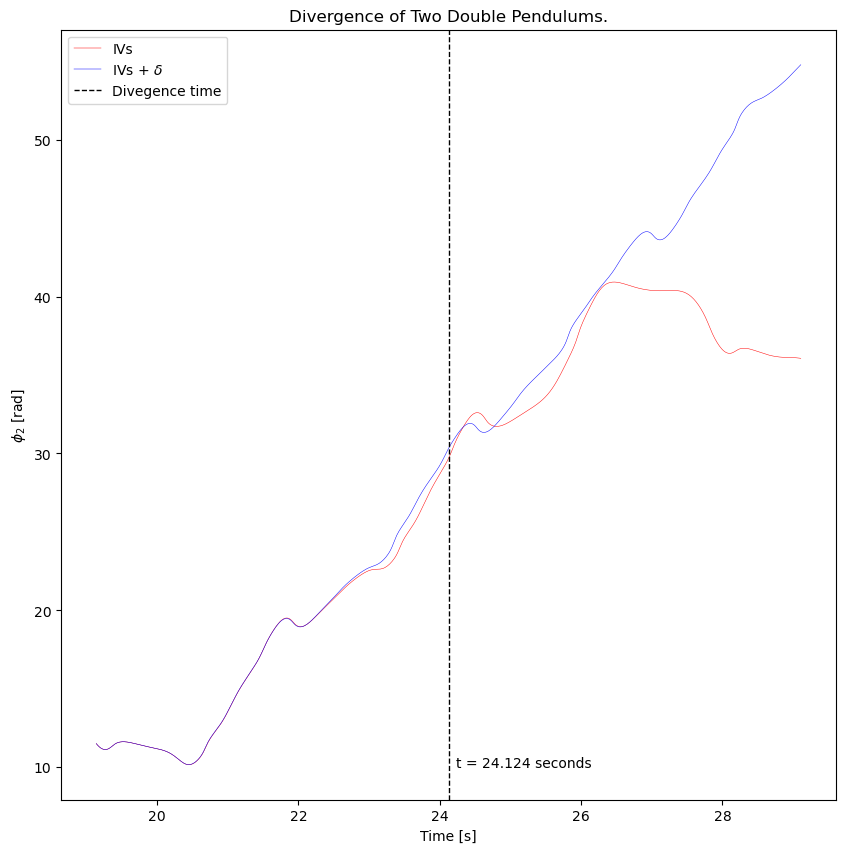

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

condition = (time_array > divergence_time - 5) & (time_array < divergence_time + 5)

ax.plot(solution_0.t[condition], solution_0.y[2][condition], color="red", linewidth=0.35, label="IVs")
ax.plot(solution_1.t[condition], solution_1.y[2][condition], color="blue", linewidth=0.35, label="IVs + $\\delta$")

plt.axvline(x=divergence_time, color='black', linestyle='--', linewidth=1, label="Divegence time")
plt.text(np.round(divergence_time, 3) + 0.1, 10, f't = {np.round(divergence_time, 3)} seconds', color='black')

plt.xlabel('Time [s]')
plt.ylabel('$\\phi_2$ [rad]')
plt.title("Divergence of Two Double Pendulums.")
plt.legend()

plt.savefig(fname="media/divergence_zoomed.png", transparent=None, dpi=500)

plt.show()

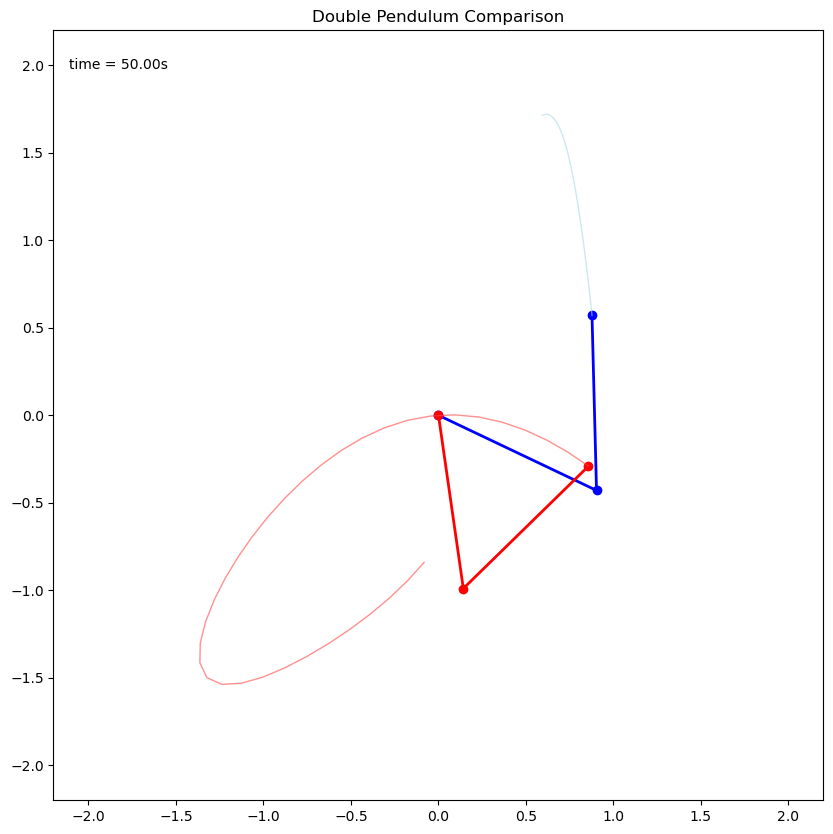

In [38]:
import matplotlib.animation as animation

M1, M2 = system.M1, system.M2
L1, L2 = system.L1, system.L2

time_length = len(time_array)
animation_time = 50
time_stop_index = np.where(time_array >= animation_time)[0][0]

phi1_1, phi2_1 = solution_0.y[0][:time_stop_index], solution_0.y[2][:time_stop_index]
phi1_2, phi2_2 = solution_1.y[0][:time_stop_index], solution_1.y[2][:time_stop_index]

t_eval = t_arr[:time_stop_index]

# COnvert to Cartesian Coordinates

x1_1 = L1 * np.sin(phi1_1)
y1_1 = -L1 * np.cos(phi1_1)
x2_1 = x1_1 + L2 * np.sin(phi2_1)
y2_1 = y1_1 - L2 * np.cos(phi2_1)

x1_2 = L1 * np.sin(phi1_2)
y1_2 = -L1 * np.cos(phi1_2)
x2_2 = x1_2 + L2 * np.sin(phi2_2)
y2_2 = y1_2 - L2 * np.cos(phi2_2)

# Animation

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.set_title("Double Pendulum Comparison")

line1, = ax.plot([], [], 'o-', lw=2, color='blue')
trace1, = ax.plot([], [], '-', lw=1, color='lightblue', alpha=0.6)

line2, = ax.plot([], [], 'o-', lw=2, color='red')
trace2, = ax.plot([], [], '-', lw=1, color='#ff4747', alpha=0.6)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

trail1_x, trail1_y = [], []
trail2_x, trail2_y = [], []
n_trails = -35

def init():
    line1.set_data([], [])
    trace1.set_data([], [])
    line2.set_data([], [])
    trace2.set_data([], [])
    time_text.set_text('')
    return line1, trace1, line2, trace2, time_text

def update(i):
    # Pendulum 1
    thisx1 = [0, x1_1[i], x2_1[i]]
    thisy1 = [0, y1_1[i], y2_1[i]]
    line1.set_data(thisx1, thisy1)
    trail1_x.append(x2_1[i])
    trail1_y.append(y2_1[i])
    trail1_x[:] = trail1_x[n_trails:]   # Limit trail to last n points
    trail1_y[:] = trail1_y[n_trails:]
    trace1.set_data(trail1_x, trail1_y)


    # Pendulum 2
    thisx2 = [0, x1_2[i], x2_2[i]]
    thisy2 = [0, y1_2[i], y2_2[i]]
    line2.set_data(thisx2, thisy2)
    trail2_x.append(x2_2[i])
    trail2_y.append(y2_2[i])
    trail2_x[:] = trail2_x[n_trails:]
    trail2_y[:] = trail2_y[n_trails:]
    trace2.set_data(trail2_x, trail2_y)

    time_text.set_text(f'time = {t_eval[i]:.2f}s')
    return line1, trace1, line2, trace2, time_text

ani = animation.FuncAnimation(fig, update, frames=len(t_eval),init_func=init, blit=True, interval=animation_time/len(t_eval)*1000)

# ani.save('media/divergence_animation.gif', writer=PillowWriter(fps=60))
ani.save("media/divergence_animation.mp4", fps=60, dpi=100, bitrate=3000, writer="ffmpeg")


### Compress .pkl files (Spoiler: Didn't help)

In [ ]:
import os

compressed_folder = 'bin_compressed'

os.makedirs(compressed_folder, exist_ok=True)

print(f"Created or verified folder: {compressed_folder}")

Created or verified folder: bin_compressed


In [34]:
import joblib

compression_level = 5

source_folder = 'bin'
dest_folder = 'bin_compressed'

In [ ]:
for filename in os.listdir(source_folder):
    if filename.endswith('.pkl'):
        source_path = os.path.join(source_folder, filename)
        dest_path = os.path.join(dest_folder, filename + '.z')

        data = joblib.load(source_path)
        joblib.dump(data, dest_path, compress=compression_level)

        print(f"Compressed: {filename} → {os.path.basename(dest_path)}")

print("All .pkl files have been compressed using joblib.")

Compressed: bifurcation_varying_phi2.pkl → bifurcation_varying_phi2.pkl.z
Compressed: poincare_general_varying_phi2.pkl → poincare_general_varying_phi2.pkl.z
Compressed: poincare_specific_phi2_0.0_T_0.1.pkl → poincare_specific_phi2_0.0_T_0.1.pkl.z
Compressed: poincare_specific_phi2_126.05_T_0.1.pkl → poincare_specific_phi2_126.05_T_0.1.pkl.z
Compressed: poincare_specific_phi2_179.91_T_0.1.pkl → poincare_specific_phi2_179.91_T_0.1.pkl.z
All .pkl files have been compressed using joblib.
